In [1]:
from dask.distributed import Client
# from dask_jobqueue import SLURMCluster

# cluster = SLURMCluster(cores=28, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='120GB', interface='ib0'
#                       ) 
# cluster.scale(196)
# # cluster.adapt(minimum=10, maximum=196)

# c = Client(cluster)
c = Client()
c

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:34141 Dashboard: http://127.0.0.1:45951/status,Cluster Workers: 8 Cores: 56 Memory: 270.19 GB


In [9]:
import xarray as xr
import numpy as np
import xscale
import gsw
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path as op
from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [11]:
ys1,ye1 = (1570,2340)
xs1,xe1 = (2730,3240)
# Sys,Sye = (1100,1600)
# Sxs,Sxe = (3000,3600)

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc')
                        ).isel(t=0)
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.isel(y=slice(ys1,ye1),x=slice(xs1,xe1))

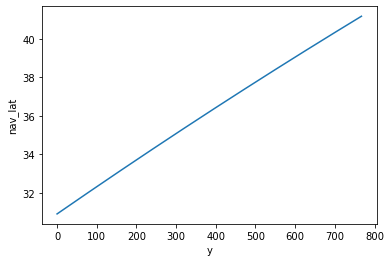

In [49]:
dsmask.nav_lat.isel(y=slice(ys+1,ye-1),x=slice(xs+1,xe-1)).mean('x').plot()

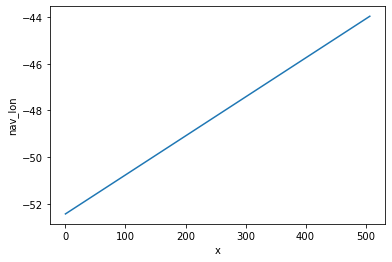

In [50]:
dsmask.nav_lon.isel(y=slice(ys+1,ye-1),x=slice(xs+1,xe-1)).mean('y').plot()

In [12]:
dsU = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridU_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(depthu=slice(None,1010))
dsV = xr.open_dataset(op.join(xtra,'00788401-00842400/eNATL60-BLBT02X_1h_20100101_20100125_gridV_20100101-20100101.nc'),
                      chunks={'time_counter':1}
                     ).sel(depthv=slice(None,1010))
dsU

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthu: 107, time_counter: 24, x: 8354, y: 4729)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
  * depthu                (depthu) float32 0.48045477 1.5587916 ... 1002.37274
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2010-01-01T00:30:00 ... 2010-01-01T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthu_bounds         (depthu, axis_nbounds) float32 dask.array<chunksize=(107, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vozocrtx              (time_counter, depthu, y, x) float32 dask.array<chunksize=(1, 107, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5251284/eNATL60-BLBT02X_1h_20100101_20100125_g...
    description:  ocean U grid variables
    title:        ocean U grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-23 13:40:54 GMT
    uuid:         01fa8081-0ae5-4c9f-8a34-7ff4227586bd
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02X_1h_20100101_20100125_gridU_20100101-2010010...
    TimeStamp:    26/03/2019 01:45:24 +0100

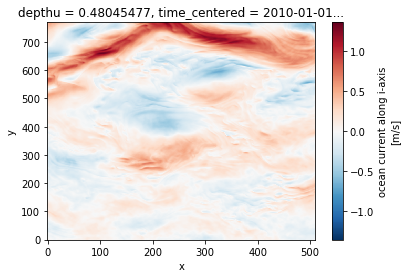

In [13]:
dsU.vozocrtx.isel(time_counter=0,depthu=0,y=slice(ys1,ye1),x=slice(xs1,xe1)).plot()

In [17]:
sys.getsizeof(dsU.vozocrtx.isel(time_counter=0,depthu=0,y=slice(ys1,ye1),x=slice(xs1,xe1)))

96

In [14]:
snpsize = (1e6              # bytes for one surface snapshot
          ) * 1e-9          # gigabytes

SSsize = (snpsize * 3       # u, v, ssh
          * (30*6*24)       # 6 months hourly (winter and summer)
         )

INsize = (snpsize * 6       # u, v, w, ssh, t, s
          * (30*6)          # 6 months daily (winter and summer)
          * 1e2             # vertical layers
         )
print(SSsize, INsize)

12.96 108.0


In [15]:
SSsize + INsize

120.96000000000001

In [16]:
((SSsize + INsize) * 3      # NA domains
 * 4                        # four models
 + (SSsize + INsize) * 1    # Agulhas domains
 * 2                        # two models
)

1693.44